# Neural Network
***
**Name**: Payoj Jain
***

## Goal

The goal of this assignment is to build a one-hidden-layer back propagation network to process real data.  For this assignment you will implement the neural net (activation function and training code) yourself, not using tensorflow or other deep learning frameworks. The purpose is for you to understand the nitty gritty of what these frameworks are doing for you before we switch over to using them.

## Data 
***

In this assignment you will be using the Occupancy Detection data set (ODD). It consists of experimental data used for binary classification of room occupancy (i.e., room is occupied versus empty) based on temperature, humidity, light, and CO2 sensors. The train and test data sets are each collected over a week period.

The data set includes time stamps with date and hour/minute/second within the day. You are **not to use time stamp features** for predicting occupancy. Since this is a commercial office building, the time stamp is a strong predictor of occupancy. Rather, the goal is to determine whether occupancy - **occ** can be sensed from:
1. temperature, expressed in degrees Celsius - **temp**
2. relative humidity, expressed as a % - **hum**
3. light, in lux - **light**
4. CO2, in ppm - **cdx**
5. humidity ratio, which is derived from the temperature and the relative humidity - **hum_ratio**

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/datatraining.txt')
X = data[['date', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temperature']].values
y = data['Occupancy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### 1. Perceptron
***

Using the perceptron code you wrote for Assignment 1, train a perceptron (linear activation function with a binary threshold) using the training set. Your perceptron should have the 5 input variables described above.

**Part A**: Report the training and test set performance in terms of % examples classified correctly.

**NOTE**: The Perceptron Update Rule is guaranteed to converge only if there is a setting of the weights that will classify the training set perfectly.  (The learning rule minimizes mistakes. When all examples are classified correctly, the weights stop changing.)  With a noisy data set like this one, the algorithm will not find an exact solution.  Also remember that the perceptron algorithm is not performing gradient descent. Instead, it will jitter around the ideal solution continually changing the weights from one iteration to the next. The weight changes will have a small effect on performance, so you'll see training set performance jitter a bit as well.

In [3]:
from sklearn.utils import shuffle
def perceptron_update(X, y, w):
#     w, incorrect = None, None
    def relu(y):
        '''
        takes a value and returns 1 if the values is greater than 0 and 0 if not
        '''
        if y>0:
            return 1
        return 0
    
    incorrect = 0
    
    for i,x in enumerate(X):
        fx = x.dot(w.T)
        fx = relu(fx)
        w = w + alpha*(x*(y[i]- fx))
        incorrect += 0 if(fx == y[i]) else 1

    return w, incorrect

def perceptron(X, y, maxIter, alpha):
    w, incorrect, it = np.zeros(X[0].size), 0, 0 
    for iter in range(maxIter):
        X,y = shuffle(X,y)
        
        w, incorrect = perceptron_update(X,y,w)
        incorrect_updates.append(incorrect)
        it += 1;
        if(iter > 100 and incorrect_updates[-2]>0 and abs(incorrect_updates[-1]-incorrect_updates[-2])/incorrect_updates[-2] < 0.001):
            break
    return w, incorrect, it
alpha = 0.001
incorrect_updates = []
w, n, i = perceptron(X_train.T[1:].T, y_train, 1000, alpha)

print(w)
print(n)
print(i)
train_accuracy = 1 - (n/X_train.shape[0])
print("Train accuracy : ", train_accuracy)

[-14.75909925000158 3.7689000000001815 0.9204083333323604
 -0.004070592657108118 -68.98334166666251]
238
102
Train accuracy :  0.9675218340611353


In [4]:
def classify(X,y,w):
    def relu(y):
        if y>0:
            return 1
        return 0
    
    correct = 0
    
    for i,x in enumerate(X):
        fx = X[i].dot(w.T)
        fx = relu(fx)
        w = w + alpha*(x*(y[i]- fx))
        correct += 1 if(fx == y[i]) else 0

    return correct

c = classify(X_test.T[1:].T, y_test, w)
print(c)
test_accuracy = c/X_test.shape[0]
print("Test Accuracy : ", test_accuracy)

799
Test Accuracy :  0.9803680981595092


### 2. 1-layer feedforward neural net
***

In this part, you will implement a 1-layer feedforward neural network from scratch as shown in the figure below.
<img src="./res/mlp_ann.png" alt="mlp_ann" style="width:500px;"/>
Your tasks are as follows:

**PART 2.A**

1. Implement `sigmoid(x)`: In this assignment, we will be using the sigmoid activation function as the non-linearity.
2. Implement `forward(x)` which calculates the activations at layer 1, 2 and 3 (stored in variables `_a01`, `_a12`, `_a23` respectively) and returns the final layer activations.
3. Implement `backward(y, y_hat)` such that it returns layer 1 and layer 2 gradients using the mean squared loss between the predicted and groundtruth vectors.
4. Implement `update(l1_grad, l2_grad)` function which will update the weights and biases stored in `_W1, _W2 and _b1, _b2`.
5. Implement`train(X, y, epochs)`.
6. Implement `predict(X)` to return one-hot encoded representation of the `_a23` layer activation.

In [5]:

rndg = np.random.RandomState(seed=0)

class MLP(object):
    """
        -- Skeleton Code for a Multi-Layer Perceptron Neural Net.
           Network has 1 input layer followed by a hidden layer and
           an output layer. 
        
    """
    def __init__(self, n_vis=5, n_hid=10, n_out=1, batch_size=7, lr=0.1):
        """
            Initialize an MLP object.
            
            params
            
            n_vis (int): # of neurons in input layer.
            n_hid (int): # of neurons in hidden layer.
            n_out (int): # number of neurons in final output layer.
            batch_size (int): # number of X,y instances in a mini-batch.
            lr (double): learning rate/step size.

            class variables:
            
            _W1, _b1 (np.ndarray): 
                Weights and biases of the input layer respectively.
            
            _W2, _b2 (np.ndarray):
                Weights and biases of the hidden layer respectively.
            
            _a01, _a12, _a23 (np.ndarray or None):
                Activations from input, hidden and output layer respectively.  
        """
        self._n_vis = n_vis
        self._n_hid = n_hid
        self._n_out = n_out
        
        self._W1 = rndg.normal(size=(self._n_hid, self._n_vis))
        self._b1 = np.ones((self._n_hid, 1))

        self._W2 = rndg.normal(size=(self._n_out, self._n_hid))
        self._b2 = np.ones((self._n_out, 1))

        self._a01 = None
        self._a12 = None
        self._a23 = None
        
        self.batch_size = batch_size
        self.lr = lr

    def sigmoid(self, X):
        """
            Sigmoid Logistic Function.
            
            params:
            
            X (np.ndarray)
            
            return:
            
            result (np.ndarray): result = f(X) 
                where f is the sigmoid function.
            
        """
#         raise NotImplementedError()
        return 1.0/(1.0+np.exp(-X.astype(float)))
        
        

    def forward(self, X):
        """
            Feed forward an input through each 
            of the layers of network.
            
            Store each layer activation in the class 
            variables defined in the constructor. You'll
            need them later during backpropogation.
            
            params:
            
            X (np.ndarray): batch_size x 5 dimensional array
            
            return:
            
            y_hat (np.ndarray): 1 x batch_size dimensional array
                representing final layer outputs.
            
        """
        
#         raise NotImplementedError()
        self._a01 = X.T
#         print("a01", self._a01.shape[0], self._a01.shape[1])
#         print("W1", self._W1.shape[0], self._W1.shape[1]) # w1 10 x 5
        self._a12 = self.sigmoid(self._W1.dot(self._a01) + self._b1)
#         print("a12", self._a12.shape[0], self._a12.shape[1]) # a12 10 X 7
        self._a23 = self.sigmoid(self._W2.dot(self._a12) + self._b2) # W2 1 X 10
#         print("a23", self._a23.shape[0], self._a23.shape[1]) # a23 1 X 7
        y_hat = self._a23


        return y_hat
        
    def backward(self, y, y_hat):
        
        """
            Implement the backpropogation algorithm.
            Assume mean squared loss at the output.
            
            params:
            
            y (np.ndarray): batch_size x 1 dimensional vector
                of grounf truth labels.
            y_hat (np.nd_array): 1 x 7 dimensional vector
                of predicted lables from forward().
            
            return:
            
            l1_grad (np.ndarray): 1 x n_hid dimensional array
                representing gradients for input layer.
                
            l2_grad (np.ndarray): n_hid x n_vis dimensional array
                representing gradients for hidden layer.
            
        """
        a01 = self._a01
        a12 = self._a12
        
#         print(y_hat, y)
#         print((y_hat - y)*(y_hat*(1-y_hat)))
        delta_12 = (y_hat - y)*(y_hat*(1-y_hat))  # 1 X 7
#         print(delta_12.shape[0], delta_12.shape[1]) 
#         db_2 = delta_12
        dW_2 = delta_12.dot(a12.T)            #change in weights is delta.transpose of a(l) # a12 = 10 X 7
#         print(dW_2.shape[0], dW_2.shape[1])         # dW_2 = 1 X 10 
        delta_01 = self._W2.T.dot(delta_12)*(a12*(1-a12))
        
#         db_1 = delta_01
        dW_1 = delta_01.dot(a01.T) # dw_1 10 X 5
#         print("dW_1", dW_1.shape[0], dW_1.shape[1])
#         raise NotImplementedError()

        l1_grad = dW_1
        l2_grad = dW_2
        
        return l1_grad, l2_grad        
    def update(self, l1_grad, l2_grad):
        """
            Implement the update rule for network weights and biases.
            
            params:
            
            l1_grad (np.ndarray): gradients for input layer.
            l2_grad (np.ndarray): gradients for hidden layer.
            
            return:
            
            none.
        """
        # TO-DO
#         print("lr :",self.lr, "l1_grad :", l1_grad, "W1 :", self._W1)
        self._W1 = self._W1 - self.lr*l1_grad
        self._W2 = self._W2 - self.lr*l2_grad 
        
    def predict(self, X, threshold = 0.5):
        """
            Returns one hot encoding of vector X using 0.5
            as the threshold.
            
            params:
            
            X (np.ndarray): predictions/activations of the output layer.
            
            return:
            
            y (np.ndarray): one hot encoding of output layer.
        """
#         Y = np.zeros(X.shape[0])
        
        y_hat = self.forward(X)
        for i in range(len(y_hat[0])):
            if y_hat[0][i]>= 0.5:
                y_hat[0][i] = 1
            else:
                y_hat[0][i] = 0
#         raise NotImplementedError()
#         print ("*************************\n", y_hat)
        return y_hat
    def train(self, X, y, epochs):
        """
            Implement the train loop for n epochs.
            In each epoch do the following:
            1. Shuffle the dataset.
            2. create self.batch_size sized-mini-batches of the dataset.
            3. get network predictions using forward().
            4. calculate the gradients using backward().
            5. update the network weights using update().
            6. Repeat 1-5 until convergence.
            
            params:
            
            X (np.ndarray): N x 5 dimensional ndarray of inputs.
            y (np.ndarray): N x 1 dimensional array of true labels.
            epochs (int): # of epochs to train the network for. 
            
            return:
            
            none.
        """
        # TO-DO

        mini_batch_size = self.batch_size
        
        for epoch in range(epochs):

            X, y = shuffle(X, y)
            
            for batch in range(0,X.shape[0],mini_batch_size):
                y_hat = self.forward(X[batch:batch+mini_batch_size])
#                 print(y_hat.shape[0], y_hat.shape[1])
                l1_grad, l2_grad = self.backward(y[batch:batch+mini_batch_size],y_hat)
                self.update(l1_grad, l2_grad)

#         raise NotImplementedError()
            
    def test(self, X_test, y_test):
        """
            Implement the test function which reports accuracy of 
            the model on the test set X_test against the true labels
            y_test.
            
            You may re-use the predict and accuracy functions defined above.
            
            params:
            
            X_test (np.ndarray): N x M dimensional array where M is the 
                number of attributes considered for training the model.
            y_test (np.ndarray): N x 1 dimensional array.
            
            return:
            
            accuracy (double): accuracy of the predicted labels against the 
                groundtruth labels.
        """
        pred = self.predict(X_test)
        accuracy = self.accuracy(y_test, pred)
        return accuracy
#         raise NotImplementedError()
    
    @classmethod
    def accuracy(self, y, y_hat):
        len_ = y.flatten().shape[0]
        acc = np.sum(y.flatten() == y_hat.flatten())/len_
#         print(acc)
        return acc

In [6]:
import unittest
from sklearn.datasets import make_classification

def load_params(path, model):
    
    params = pickle.load(open(path, 'rb'))
    for key in params:
        model.__dict__[key] = params[key]

class TestMLP(unittest.TestCase):
    def setUp(self):
        
        self.net = MLP()
        self.pre_trained_model = load_params("./res/mlp.pkl", self.net)
        self.X = np.load("./res/x.npy")
        self.y = np.load("./res/y.npy")
        self.p = np.load("./res/p.npy")
        self.sigX = np.asarray([-1, -2, -3, 0, 1, 2, 3])
    
    def test_forward(self):
        self.assertEqual(np.sum(self.net.forward(self.X[901:])), np.sum(self.p))
    
    def test_train(self):
        x, y = make_classification(
            n_samples=1000,
            n_features=5,
            n_redundant=0,
            random_state=rndg
        )
        net = MLP(5, 10, 1, 7, 0.01)
        net.train(self.X[:900], self.y[:900], 100)
#         print (self.y[901:])
        self.assertTrue(net.accuracy(net.predict(self.X[901:]), self.y[901:]) > 0.88)
    
    def test_sigmoid(self):
        self.assertEqual(
            np.sum(self.net.sigmoid(self.sigX)), 3.5
        )
        
suite = unittest.TestLoader().loadTestsFromTestCase(TestMLP)
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.617s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

**PART 2.B**

Report the baseline performance of the untrained MLP that you built in **PART 2.A** using the selected values. To calculate the baseline score, feed-forward entire test set through the test function. The test function will return a set of predictions. Calculate the accuracy of these predictions against ground truth training lables.  
Report:
1. accuracy

In [7]:
### Part 2.B
net = MLP()
baseline_accuracy = net.test(X_test.T[1:].T, y_test)
baseline_accuracy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


0.21963190184049081

**PART 2.C**

Select a learning rate, batch size and train the network for 100 epochs. After each epoch plot a graph of netowrk's accuracy on the test data. On the same graph, plot a constant horizontal line of the baseline score that you reported in **PART 2.B**.  

Report:
1. learning rate
2. batch size

In [11]:
### Part 2.C
from matplotlib import pyplot as plt

epochs = 100
accuracy_history = []
lr, batch_size = 0.0002,10
net = MLP(5, 5, 1, batch_size, lr)
X_train_p2 = X_train.T[1:].T
X_test_p2 = X_test.T[1:].T
for epoch in range(1,epochs+1):

    net.train(X_train_p2, y_train, epoch)
    acc = net.test(X_test_p2, y_test)
#     print(acc)
    accuracy_history.append(acc)
# print(accuracy_history)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


> Learning Rate : 0.0002  
Batch size = 10

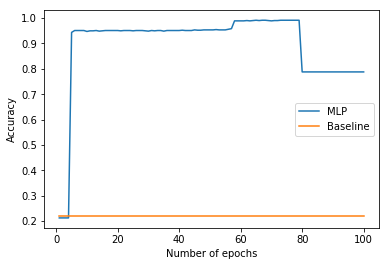

In [12]:
epochs = [e for e in range(1,101)]
plt.plot(epochs, accuracy_history, label = 'MLP')
plt.plot(epochs, [baseline_accuracy]*100, label = 'Baseline')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
p2_train_accuracy = net.test(X_train_p2, y_train)
print(p2_train_accuracy)

0.787254366812


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


**PART 2.D**

Now train nets with varying size of the hidden layer $H={1, 2, 5, 10..}$ for max epochs = 100. Make a plot of the nets' accuracy on test set as a function of $H$.

In [17]:
### Part 2.D
H = [1,2,5,10,15,20,25,30]
epochs = 100
hidden_accuracy_history = []
lr, batch_size = 0.002,10
for h in H:
    net = MLP(5, h, 1, batch_size, lr)
    net.train(X_train.T[1:].T, y_train, epochs)
    acc = net.test(X_test.T[1:].T, y_test)
    hidden_accuracy_history.append(acc)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


In [19]:
hidden_accuracy_history

[0.78773006134969326,
 0.21226993865030674,
 0.78773006134969326,
 0.78773006134969326,
 0.78773006134969326,
 0.94233128834355828,
 0.94233128834355828,
 0.96196319018404908]

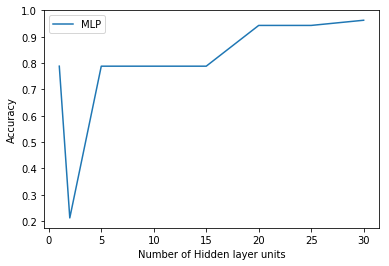

In [18]:
plt.plot(H,hidden_accuracy_history, label='MLP')
plt.xlabel("Number of Hidden layer units")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 3. Extra Credit

See how much adding information about time of day helps the network. Add a new set of inputs that represent the time of day. (Don't add information about day of week or absolute date.)  


**PART 3.A**  

Determine an appropriate representation for the time of day. Describe the representation you used. For example, you might add one unit with a value ranging from 0 to 1 for times ranging from 00:00 to 23:59. Report the representation you selected.


**Representing Time as a feature**  
>My idea for representing time as a feature in the input layer is to ignore the date and convert the time into seconds. Normalising these resultant time by subtracting the minimum from each training example time and dividing the difference with the maximum time

In [20]:
### Part 3.A
import datetime
import time

times_of_day = X.T[0]
time_feature = np.array([time.mktime(datetime.datetime.strptime(t.split()[1],"%H:%M:%S").timetuple()) for t in times_of_day])

# taking z-norm. Subtracting the minimum time from each and then dividing eaach time with the max
time_feature -= min(time_feature)
time_feature /= max(time_feature)
time_feature

array([ 0.74427547,  0.74495883,  0.74566534, ...,  0.39679635,
        0.39750287,  0.3981978 ])

**PART 3.B**  

Train your net with $H=5$ hidden and compare training and test set performance to the net you built in (2e)

In [ ]:
### Part 3.B

In [21]:
new_feature = np.array([time_feature])
new_X = np.concatenate((X.T[1:].T, new_feature.T), axis = 1)

In [22]:
lr, batch_size = 0.001, 10
n_vis, n_hid, n_out = 6, 5, 1
epochs = 100

In [28]:
# Test performance with time as a feature
X_train_p3, X_test_p3, y_train, y_test = train_test_split(new_X, y, test_size=0.1)
net = MLP(n_vis, n_hid, n_out, batch_size, lr)
net.train(X_train_p3, y_train, epochs)
p3_test_accuracy = net.test(X_test_p3, y_test)
p3_train_accuracy = net.test(X_train_p3, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp


In [33]:
# Comparing Test performance for models with and without time as a feature
print("Test performance after 100 epochs for model WITHOUT time as a feature (lr: 0.002, batch_size: 10):", accuracy_history[-1])
print("Test performance after 100 epochs for model with time as a feature (lr: 0.002, batch_size: 10)   :", p3_test_accuracy)

Test performance after 100 epochs for model WITHOUT time as a feature (lr: 0.002, batch_size: 10): 0.78773006135
Test performance after 100 epochs for model with time as a feature (lr: 0.002, batch_size: 10)   : 0.946012269939


In [34]:
# Train accuracy without time as a feature
print("Training performance after 100 epochs for model WITHOUT time as a feature (lr: 0.002, batch_size: 10):", p2_train_accuracy)
print("Training performance after 100 epochs for model with time as a feature (lr: 0.002, batch_size: 10)   :", p3_train_accuracy)

Training performance after 100 epochs for model WITHOUT time as a feature (lr: 0.002, batch_size: 10): 0.787254366812
Training performance after 100 epochs for model with time as a feature (lr: 0.002, batch_size: 10)   : 0.938455240175
